This notebook includes the notes and the exercises of Week 3 of Crash course in Causality, Penn University

Colab Link: https://colab.research.google.com/drive/1_Sn5X7A7QhPGlrfDXeRJAzV752_0XtUi

References:
- Crash course in Causality, Penn University, Coursera
- https://sejdemyr.github.io/r-tutorials/statistics/tutorial8.html 
- https://rpubs.com/willdebras/causalinf

**Set Environment**


In [1]:
#set R environment
cat(system('python3 -c "from google.colab import drive\ndrive.mount()"', intern=TRUE), sep='\n', wait=TRUE)

Warning message in system("python3 -c \"from google.colab import drive\ndrive.mount()\"", :
“running command 'python3 -c "from google.colab import drive
drive.mount()"' had status 1”



TRUE


In [2]:
install.packages('tableone')
install.packages('Matching')
install.packages('MatchIt')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘nloptr’, ‘statmod’, ‘RcppEigen’, ‘minqa’, ‘numDeriv’, ‘mitools’, ‘gdata’, ‘lme4’, ‘survey’, ‘e1071’, ‘zoo’, ‘gmodels’, ‘lmerTest’, ‘labelled’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library('tableone')
library('Matching')
library('MatchIt')

Loading required package: MASS

## 
##  Matching (Version 4.9-7, Build Date: 2020-02-05)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##




**Load Data**

In [0]:
df <- read.csv(url("http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/rhc.csv"))

In [5]:
head(df)

,X,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,⋯,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
,<int>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<fct>,<int>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>,<int>
1,1,COPD,NA,Yes,11142,11151,NA,11382,No,0,⋯,No,No,No,No,No,0,NA,white,Under $11k,5
2,2,MOSF w/Sepsis,NA,No,11799,11844,11844,11844,Yes,1,⋯,No,No,Yes,No,No,NA,1437,white,Under $11k,7
3,3,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143,NA,12400,No,0,⋯,No,No,No,No,No,NA,599,white,$25-$50k,9
4,4,ARF,NA,No,11146,11183,11183,11182,Yes,0,⋯,No,No,No,No,No,NA,NA,white,$11-$25k,10
5,5,MOSF w/Sepsis,NA,No,12035,12037,12037,12036,Yes,0,⋯,No,No,No,No,No,NA,64,white,Under $11k,11
6,6,COPD,NA,No,12389,12396,NA,12590,No,0,⋯,No,No,No,No,No,0,242,white,Under $11k,12


In [0]:
#create a data set with just these variables, for simplicity
ARF<-as.numeric(df$cat1=='ARF')
CHF<-as.numeric(df$cat1=='CHF')
Cirr<-as.numeric(df$cat1=='Cirrhosis')
colcan<-as.numeric(df$cat1=='Colon Cancer')
Coma<-as.numeric(df$cat1=='Coma')
COPD<-as.numeric(df$cat1=='COPD')
lungcan<-as.numeric(df$cat1=='Lung Cancer')
MOSF<-as.numeric(df$cat1=='MOSF w/Malignancy')
sepsis<-as.numeric(df$cat1=='MOSF w/Sepsis')
female<-as.numeric(df$sex=='Female')
died<-as.numeric(df$death=='Yes')
age<-df$age
treatment<-as.numeric(df$swang1=='RHC')
meanbp1<-df$meanbp1

In [0]:
#new dataset
mydata<-cbind(ARF,CHF,Cirr,colcan,Coma,lungcan,MOSF,sepsis,
              age,female,meanbp1,treatment,died)
mydata<-data.frame(mydata)

In [0]:
#covariates we will use (shorter list than you would use in practice)
xvars<-c("ARF","CHF","Cirr","colcan","Coma","lungcan","MOSF","sepsis",
         "age","female","meanbp1")

In [9]:
#look at a table 1
table1<- CreateTableOne(vars=xvars,strata="treatment", data=mydata, test=FALSE)
## include standardized mean difference (SMD)
print(table1,smd=TRUE)

                     Stratified by treatment
                      0             1             SMD   
  n                    3551          2184               
  ARF (mean (SD))      0.45 (0.50)   0.42 (0.49)   0.059
  CHF (mean (SD))      0.07 (0.25)   0.10 (0.29)   0.095
  Cirr (mean (SD))     0.05 (0.22)   0.02 (0.15)   0.145
  colcan (mean (SD))   0.00 (0.04)   0.00 (0.02)   0.038
  Coma (mean (SD))     0.10 (0.29)   0.04 (0.20)   0.207
  lungcan (mean (SD))  0.01 (0.10)   0.00 (0.05)   0.095
  MOSF (mean (SD))     0.07 (0.25)   0.07 (0.26)   0.018
  sepsis (mean (SD))   0.15 (0.36)   0.32 (0.47)   0.415
  age (mean (SD))     61.76 (17.29) 60.75 (15.63)  0.061
  female (mean (SD))   0.46 (0.50)   0.41 (0.49)   0.093
  meanbp1 (mean (SD)) 84.87 (38.87) 68.20 (34.24)  0.455


# Greedy matching on Mahalanobis distance

there is 0.054 more probability to die from the treatment with p-value = 8.799e-05

In [10]:
# Match does the match for you
greedymatch<-Match(Tr=treatment,M=1,X=mydata[xvars],replace=FALSE)
matched<-mydata[unlist(greedymatch[c("index.treated","index.control")]), ]

#get table 1 for matched data with standardized differences
matchedtab1<-CreateTableOne(vars=xvars, strata ="treatment", 
                            data=matched, test = FALSE)
print(matchedtab1, smd = TRUE)

#outcome analysis
y_trt<-matched$died[matched$treatment==1]
y_con<-matched$died[matched$treatment==0]

#pairwise difference
diffy<-y_trt-y_con

#paired t-test
t.test(diffy)

#McNemar test
table(y_trt,y_con)

mcnemar.test(matrix(c(973,513,395,303),2,2))

                     Stratified by treatment
                      0             1             SMD   
  n                    2184          2184               
  ARF (mean (SD))      0.42 (0.49)   0.42 (0.49)   0.006
  CHF (mean (SD))      0.10 (0.29)   0.10 (0.29)  <0.001
  Cirr (mean (SD))     0.02 (0.15)   0.02 (0.15)  <0.001
  colcan (mean (SD))   0.00 (0.02)   0.00 (0.02)  <0.001
  Coma (mean (SD))     0.04 (0.20)   0.04 (0.20)  <0.001
  lungcan (mean (SD))  0.00 (0.05)   0.00 (0.05)  <0.001
  MOSF (mean (SD))     0.07 (0.26)   0.07 (0.26)  <0.001
  sepsis (mean (SD))   0.24 (0.43)   0.32 (0.47)   0.177
  age (mean (SD))     61.53 (16.15) 60.75 (15.63)  0.049
  female (mean (SD))   0.44 (0.50)   0.41 (0.49)   0.042
  meanbp1 (mean (SD)) 73.12 (34.28) 68.20 (34.24)  0.144



	One Sample t-test

data:  diffy
t = 3.9289, df = 2183, p-value = 8.799e-05
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.02706131 0.08099730
sample estimates:
mean of x 
0.0540293 


     y_con
y_trt   0   1
    0 303 395
    1 513 973


	McNemar's Chi-squared test with continuity correction

data:  matrix(c(973, 513, 395, 303), 2, 2)
McNemar's chi-squared = 15.076, df = 1, p-value = 0.0001033


# propensity score estimation with logistic regression

propensity is the probability of receiving the treatment rather than the control. Suppose old people are more likely to receive the treatment the probability will be higher of a 70 years old individual than a 30 years old one. In the creation of two groups if you match propensity score you should acheive balance.

Coefficients estimate will communicate if one group is more or less likely to be tested. Here we can see that female is less likely to be tested with a significant p value


In [11]:
#fit a propensity score model. logistic regression

psmodel<-glm(treatment~ARF+CHF+Cirr+colcan+Coma+lungcan+MOSF+
               sepsis+age+female+meanbp1,
    family=binomial(),data=mydata)

#show coefficients etc
summary(psmodel)
#create propensity score
pscore<-psmodel$fitted.values


Call:
glm(formula = treatment ~ ARF + CHF + Cirr + colcan + Coma + 
    lungcan + MOSF + sepsis + age + female + meanbp1, family = binomial(), 
    data = mydata)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7013  -1.0097  -0.6336   1.1814   2.4791  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.7299671  0.1997692  -3.654 0.000258 ***
ARF          1.2931956  0.1487784   8.692  < 2e-16 ***
CHF          1.6804704  0.1715672   9.795  < 2e-16 ***
Cirr         0.5234506  0.2181458   2.400 0.016416 *  
colcan       0.0295468  1.0985361   0.027 0.978542    
Coma         0.7013451  0.1854937   3.781 0.000156 ***
lungcan     -0.0869570  0.5039331  -0.173 0.863000    
MOSF         1.3046587  0.1772705   7.360 1.84e-13 ***
sepsis       2.0433604  0.1545437  13.222  < 2e-16 ***
age         -0.0031374  0.0017289  -1.815 0.069567 .  
female      -0.1697903  0.0583574  -2.909 0.003620 ** 
meanbp1     -0.0109824  0.0008217 -13.366  < 2e

In [23]:
summary(pscore)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00908 0.04854 0.12068 0.30130 0.63872 0.85315 

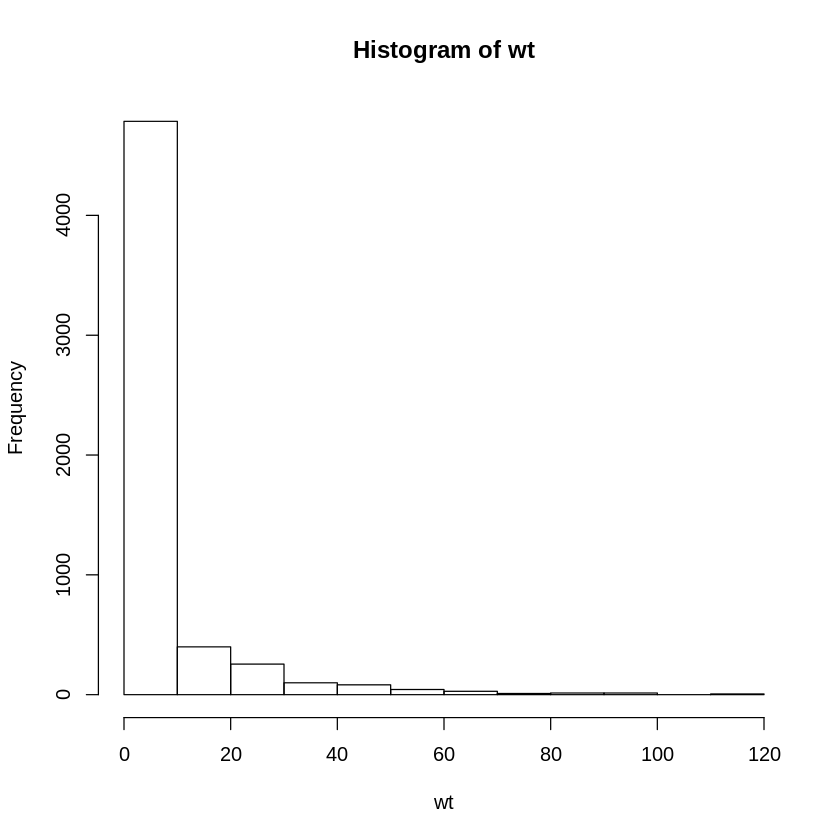

In [28]:
wt<-ifelse(treatment==1,1/pscore,1/(1-pscore))
hist(wt)

# Matching with a Capiler

Matched will use the pscore to create comparable groups.

Caliper ensures we do not have any bad matches. Smaller Caliper , less biais more variance

In [13]:
#do greedy matching on logit(PS) using Match with a caliper
logit <- function(p) {log(p)-log(1-p)}
psmatch<-Match(Tr=mydata$treatment,M=1,X=logit(pscore),replace=FALSE,caliper=.2)
matched<-mydata[unlist(psmatch[c("index.treated","index.control")]), ]
xvars<-c("ARF","CHF","Cirr","colcan","Coma","lungcan","MOSF","sepsis",
         "age","female","meanbp1")
#get standardized differences
matchedtab1<-CreateTableOne(vars=xvars, strata ="treatment", 
                            data=matched, test = FALSE)
print(matchedtab1, smd = TRUE)

#outcome analysis
y_trt<-matched$died[matched$treatment==1]
y_con<-matched$died[matched$treatment==0]

#pairwise difference
diffy<-y_trt-y_con

#paired t-test
t.test(diffy)

                     Stratified by treatment
                      0             1             SMD   
  n                    1932          1932               
  ARF (mean (SD))      0.47 (0.50)   0.47 (0.50)   0.003
  CHF (mean (SD))      0.10 (0.30)   0.09 (0.29)   0.023
  Cirr (mean (SD))     0.03 (0.16)   0.03 (0.16)   0.007
  colcan (mean (SD))   0.00 (0.02)   0.00 (0.02)  <0.001
  Coma (mean (SD))     0.05 (0.21)   0.05 (0.22)   0.012
  lungcan (mean (SD))  0.00 (0.05)   0.00 (0.05)   0.011
  MOSF (mean (SD))     0.08 (0.27)   0.08 (0.27)   0.002
  sepsis (mean (SD))   0.25 (0.43)   0.25 (0.43)   0.004
  age (mean (SD))     61.36 (17.66) 60.91 (15.52)  0.027
  female (mean (SD))   0.44 (0.50)   0.43 (0.49)   0.021
  meanbp1 (mean (SD)) 71.76 (34.09) 70.99 (35.02)  0.022



	One Sample t-test

data:  diffy
t = 3.2837, df = 1931, p-value = 0.001043
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.02022119 0.08019288
sample estimates:
 mean of x 
0.05020704 


# Matching with MatchIt

The jitter of matchit will plot 4 charts. There are no unmatched treated. So everybody in the treated group was matched with someone from the untreated group. There was a significant amount in the control group which had no match with the treated group. The low propensity score for control group was over represented


Call:
matchit(formula = treatment ~ ARF + CHF + Cirr + colcan + Coma + 
    lungcan + MOSF + sepsis + age + female + meanbp1, data = mydata, 
    method = "nearest")

Summary of balance for all data:
         Means Treated Means Control SD Control Mean Diff eQQ Med eQQ Mean
distance        0.4456        0.3410     0.1526    0.1046  0.1133   0.1047
ARF             0.4162        0.4452     0.4971   -0.0290  0.0000   0.0288
CHF             0.0957        0.0696     0.2544    0.0261  0.0000   0.0261
Cirr            0.0224        0.0493     0.2165   -0.0268  0.0000   0.0266
colcan          0.0005        0.0017     0.0411   -0.0012  0.0000   0.0014
Coma            0.0435        0.0960     0.2947   -0.0525  0.0000   0.0527
lungcan         0.0023        0.0096     0.0974   -0.0073  0.0000   0.0073
MOSF            0.0723        0.0679     0.2516    0.0045  0.0000   0.0046
sepsis          0.3205        0.1484     0.3556    0.1721  0.0000   0.1722
age            60.7498       61.7609    17.2877  

[1] "To identify the units, use first mouse button; to stop, use second."


integer(0)

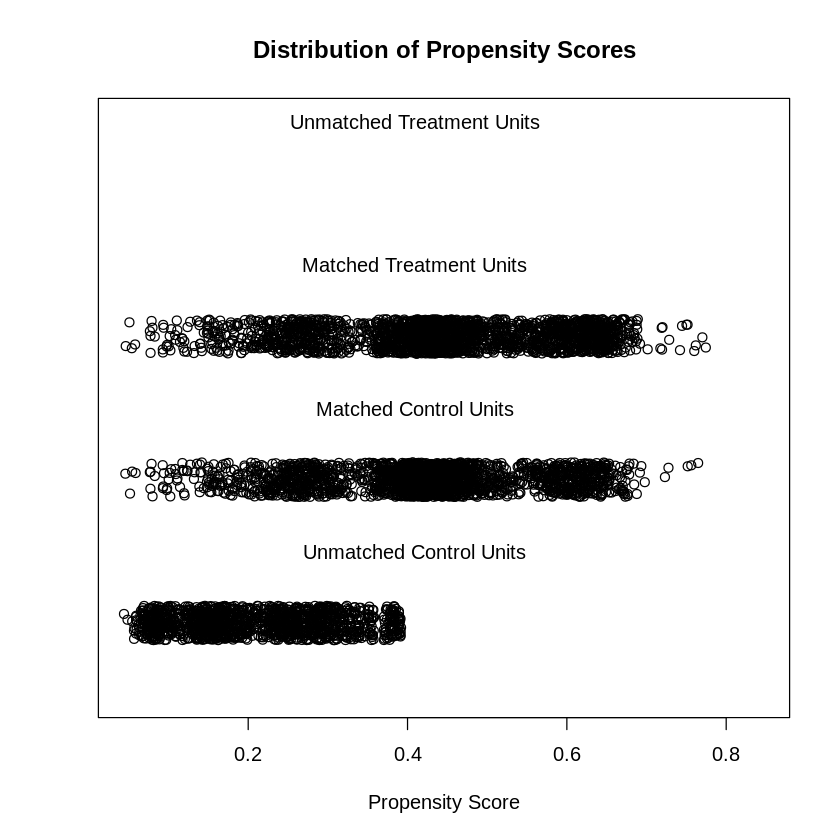

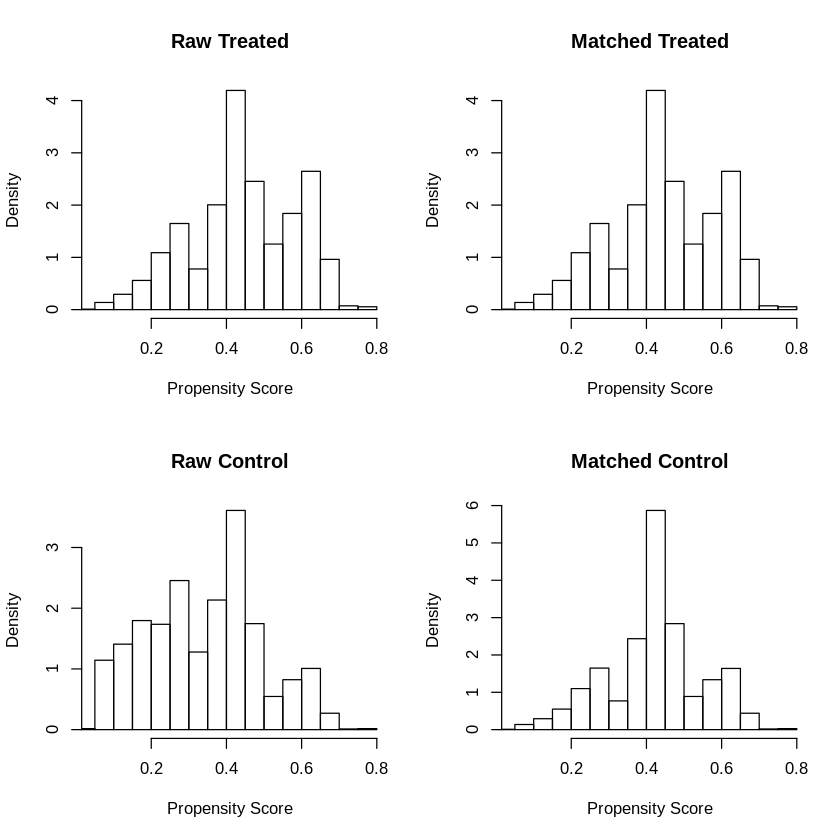

In [14]:
#use MatchIt nearest neighbour for Propensity score

m.out <-matchit(treatment~ARF+CHF+Cirr+colcan+Coma+lungcan+MOSF+
               sepsis+age+female+meanbp1,data=mydata,method='nearest')
summary(m.out)
plot(m.out,type='jitter')
plot(m.out,type='hist')

# Course Data analysis project

For this assignment we will use data from Lalonde (1986), that aimed to evaluate the impact of National Supported Work (NSW) Demonstration, which is a labor training program, on post-intervention income levels. Interest is in estimating the causal effect of this training program on income.

The data have n=614 subjects and 10 variables

* age age in years.

* educ years of schooling.

* black indicator variable for blacks.

* hispan indicator variable for Hispanics.

* married indicator variable for marital status.

* nodegree indicator variable for high school diploma.

* re74 real earnings in 1974.

* re75 real earnings in 1975.

* re78 real earnings in 1978.

* treat an indicator variable for treatment status.

The outcome is re78 – post-intervention income.

The treatment is treat – which is equal to 1 if the subject received the labor training and equal to 0 otherwise.

** The potential confounding variables are: age, educ, black, hispan, married, nodegree, re74, re75.**

In [15]:
data(lalonde, package = 'MatchIt')
head(lalonde)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
NSW1,1,37,11,1,0,1,1,0,0,9930.0460
NSW2,1,22,9,0,1,0,1,0,0,3595.8940
NSW3,1,30,12,1,0,0,0,0,0,24909.4500
NSW4,1,27,11,1,0,0,1,0,0,7506.1460
NSW5,1,33,8,1,0,0,1,0,0,289.7899
NSW6,1,22,9,1,0,0,1,0,0,4056.4940


## Question 1

Find the standardized differences for all of the confounding variables (pre-matching). What is the standardized difference for married (to nearest hundredth)?

In [0]:
#covariates we will use (shorter list than you would use in practice)
xvars<-c("treat","age","educ","black","hispan","married","nodegree","re74","re75","re78")

In [17]:
table1<- CreateTableOne(vars=xvars,strata="treat", data=lalonde, test=FALSE)
## include standardized mean difference (SMD)
print(table1,smd=TRUE)

                      Stratified by treat
                       0                 1                 SMD   
  n                        429               185                 
  treat (mean (SD))       0.00 (0.00)       1.00 (0.00)     Inf  
  age (mean (SD))        28.03 (10.79)     25.82 (7.16)     0.242
  educ (mean (SD))       10.24 (2.86)      10.35 (2.01)     0.045
  black (mean (SD))       0.20 (0.40)       0.84 (0.36)     1.668
  hispan (mean (SD))      0.14 (0.35)       0.06 (0.24)     0.277
  married (mean (SD))     0.51 (0.50)       0.19 (0.39)     0.719
  nodegree (mean (SD))    0.60 (0.49)       0.71 (0.46)     0.235
  re74 (mean (SD))     5619.24 (6788.75) 2095.57 (4886.62)  0.596
  re75 (mean (SD))     2466.48 (3292.00) 1532.06 (3219.25)  0.287
  re78 (mean (SD))     6984.17 (7294.16) 6349.14 (7867.40)  0.084


## Question 2

What is the raw (unadjusted) mean of real earnings in 1978 for treated subjects minus the mean of real earnings in 1978 for untreated subjects?

In [18]:
6349.14-6984.17

[1] -635.03

## Instructions
Fit a propensity score model. Use a logistic regression model, where the outcome is treatment. Include the 8 confounding variables in the model as predictors, with no interaction terms or non-linear terms (such as squared terms). **Obtain the propensity score for each subject.** https://sejdemyr.github.io/r-tutorials/statistics/tutorial8.html

In [26]:
#fit a propensity score model. logistic regression

psmodel<-glm(treat~age+educ+black+hispan+married+nodegree+re74+re75,
    family=binomial(),data=lalonde)

#show coefficients etc
summary(psmodel)
#create propensity score
pscore<-psmodel$fitted.values



Call:
glm(formula = treat ~ age + educ + black + hispan + married + 
    nodegree + re74 + re75, family = binomial(), data = lalonde)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7645  -0.4736  -0.2862   0.7508   2.7169  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.729e+00  1.017e+00  -4.649 3.33e-06 ***
age          1.578e-02  1.358e-02   1.162  0.24521    
educ         1.613e-01  6.513e-02   2.477  0.01325 *  
black        3.065e+00  2.865e-01  10.699  < 2e-16 ***
hispan       9.836e-01  4.257e-01   2.311  0.02084 *  
married     -8.321e-01  2.903e-01  -2.866  0.00415 ** 
nodegree     7.073e-01  3.377e-01   2.095  0.03620 *  
re74        -7.178e-05  2.875e-05  -2.497  0.01253 *  
re75         5.345e-05  4.635e-05   1.153  0.24884    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 751.49  on 613  degrees of freedom
Residu

## Question 3
What are the minimum and maximum values of the estimated propensity score?

In [27]:
summary(pscore)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00908 0.04854 0.12068 0.30130 0.63872 0.85315 

# Instructions

Now carry out propensity score matching using the Match function.

Before using the Match function, first do:

>set.seed(931139)

Setting the seed will ensure that you end up with a matched data set that is the same as the one used to create the solutions.

Use options to specify pair matching, without replacement, no caliper.

Match on the propensity score itself, not logit of the propensity score. Obtain the standardized differences for the matched data.



In [42]:
set.seed(931139)
xvars = c('age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75')
ps_matched = Match(Tr=lalonde$treat, X=pscore, replace=FALSE, M=1)
matched_data = lalonde[unlist(ps_matched[c("index.treated", "index.control")]),] 
table1_ps_matched = CreateTableOne(vars=xvars, data=matched_data, strata = "treat")
print(table1_ps_matched, smd=TRUE)
dim(matched_data)

                      Stratified by treat
                       0                 1                 p      test SMD   
  n                        185               185                             
  age (mean (SD))        25.29 (10.65)     25.82 (7.16)     0.575       0.058
  educ (mean (SD))       10.55 (2.71)      10.35 (2.01)     0.421       0.084
  black (mean (SD))       0.47 (0.50)       0.84 (0.36)    <0.001       0.852
  hispan (mean (SD))      0.21 (0.41)       0.06 (0.24)    <0.001       0.453
  married (mean (SD))     0.20 (0.40)       0.19 (0.39)     0.794       0.027
  nodegree (mean (SD))    0.65 (0.48)       0.71 (0.46)     0.222       0.127
  re74 (mean (SD))     2351.12 (4192.62) 2095.57 (4886.62)  0.590       0.056
  re75 (mean (SD))     1605.02 (2601.68) 1532.06 (3219.25)  0.811       0.025


[1] 370  10


Call:
matchit(formula = treat ~ age + educ + black + hispan + married + 
    nodegree + re74 + re75, data = lalonde, method = "nearest")

Summary of balance for all data:
         Means Treated Means Control SD Control  Mean Diff   eQQ Med  eQQ Mean
distance        0.5774        0.1822     0.2295     0.3952    0.5176    0.3955
age            25.8162       28.0303    10.7867    -2.2141    1.0000    3.2649
educ           10.3459       10.2354     2.8552     0.1105    1.0000    0.7027
black           0.8432        0.2028     0.4026     0.6404    1.0000    0.6432
hispan          0.0595        0.1422     0.3497    -0.0827    0.0000    0.0811
married         0.1892        0.5128     0.5004    -0.3236    0.0000    0.3243
nodegree        0.7081        0.5967     0.4911     0.1114    0.0000    0.1135
re74         2095.5737     5619.2365  6788.7508 -3523.6628 2425.5720 3620.9240
re75         1532.0553     2466.4844  3291.9962  -934.4291  981.0968 1060.6582
           eQQ Max
distance    0.5966


[1] "To identify the units, use first mouse button; to stop, use second."


integer(0)

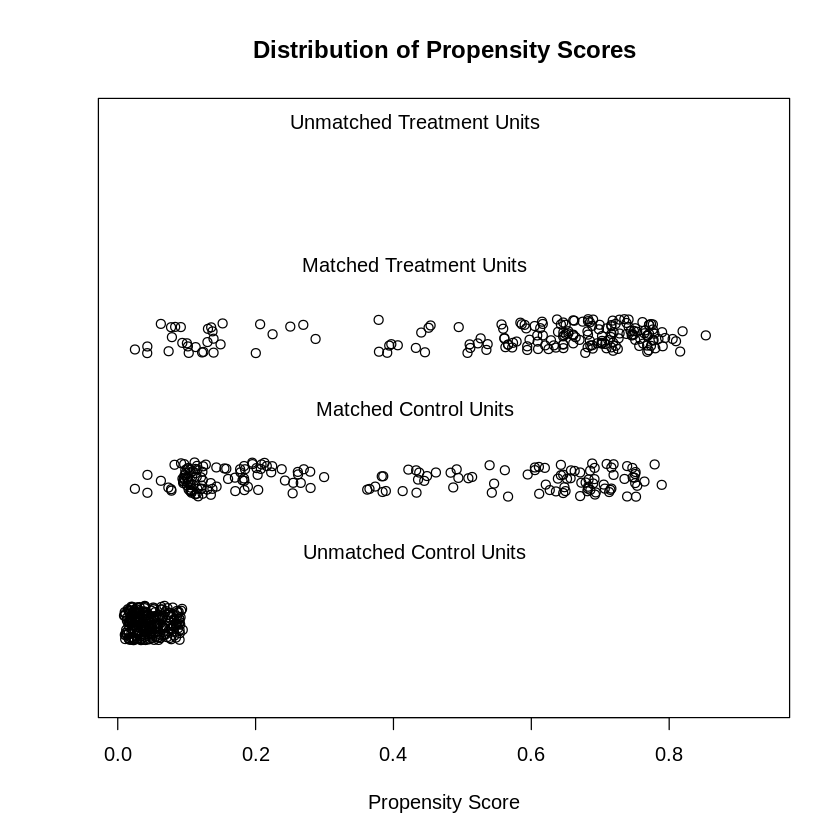

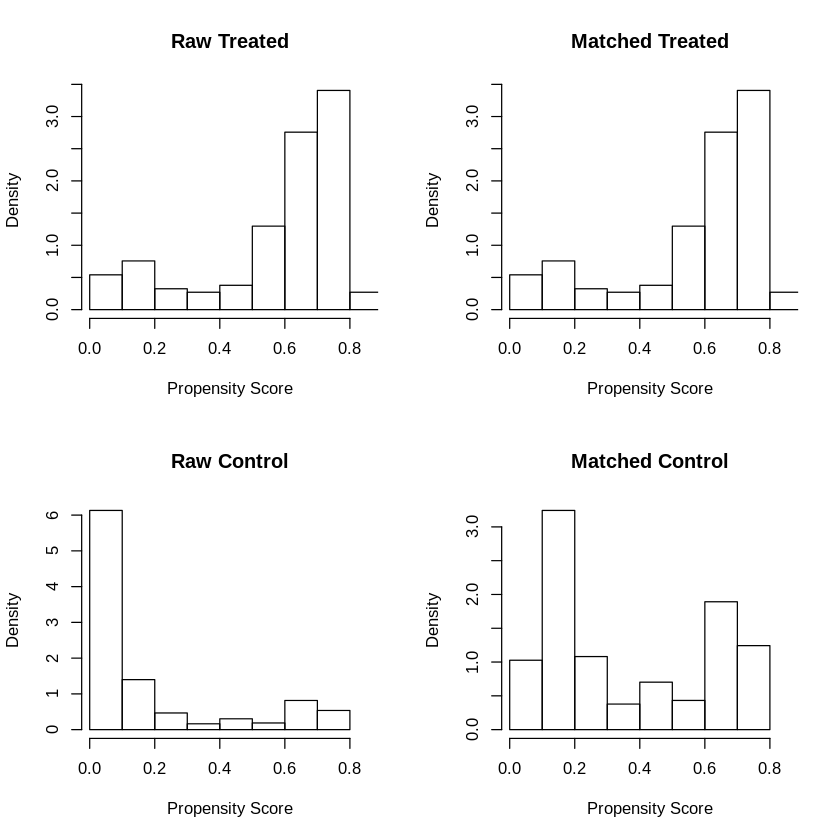

In [32]:
set.seed(931139)
#use MatchIt nearest neighbour for Propensity score

m.out <-matchit(treat~age+educ+black+hispan+married+nodegree+re74+re75,data=lalonde,method='nearest')
summary(m.out)
plot(m.out,type='jitter')
plot(m.out,type='hist')


## Question 5

For the propensity score matched data:

Which variable has the largest standardized difference?

In [45]:
print(table1_ps_matched, smd=TRUE)

                      Stratified by treat
                       0                 1                 p      test SMD   
  n                        185               185                             
  age (mean (SD))        25.29 (10.65)     25.82 (7.16)     0.575       0.058
  educ (mean (SD))       10.55 (2.71)      10.35 (2.01)     0.421       0.084
  black (mean (SD))       0.47 (0.50)       0.84 (0.36)    <0.001       0.852
  hispan (mean (SD))      0.21 (0.41)       0.06 (0.24)    <0.001       0.453
  married (mean (SD))     0.20 (0.40)       0.19 (0.39)     0.794       0.027
  nodegree (mean (SD))    0.65 (0.48)       0.71 (0.46)     0.222       0.127
  re74 (mean (SD))     2351.12 (4192.62) 2095.57 (4886.62)  0.590       0.056
  re75 (mean (SD))     1605.02 (2601.68) 1532.06 (3219.25)  0.811       0.025


## Instructions

Re-do the matching, but use a caliper this time. Set the caliper=0.1 in the options in the Match function.

Again, before running the Match function, set the seed:

>set.seed(931139)



## Question 6
How many matched pairs are there?

In [52]:
set.seed(931139)
#do greedy matching on logit(PS) using Match with a caliper
logit <- function(p) {log(p)-log(1-p)}
psmatch<-Match(Tr=lalonde$treat,M=1,X=logit(pscore),replace=FALSE,caliper=.1)
matched<-lalonde[unlist(psmatch[c("index.treated","index.control")]), ]
xvars<-c("treat","age","educ","black","hispan","married","nodegree","re74","re75")
#get standardized differences
matchedtab1<-CreateTableOne(vars=xvars, strata ="treat", 
                            data=matched, test = FALSE)
print(matchedtab1, smd = TRUE)


                      Stratified by treat
                       0                 1                 SMD   
  n                        111               111                 
  treat (mean (SD))       0.00 (0.00)       1.00 (0.00)     Inf  
  age (mean (SD))        26.33 (11.05)     26.03 (6.92)     0.033
  educ (mean (SD))       10.47 (2.65)      10.27 (2.30)     0.080
  black (mean (SD))       0.72 (0.45)       0.74 (0.44)     0.040
  hispan (mean (SD))      0.13 (0.33)       0.10 (0.30)     0.085
  married (mean (SD))     0.25 (0.44)       0.23 (0.43)     0.042
  nodegree (mean (SD))    0.61 (0.49)       0.65 (0.48)     0.074
  re74 (mean (SD))     2601.08 (4595.00) 2238.16 (5722.69)  0.070
  re75 (mean (SD))     1914.65 (2978.70) 1088.15 (2637.34)  0.294


## Instructions
Use the matched data set (from propensity score matching with caliper=0.1) to carry out the outcome analysis.



## Question 7
For the matched data, what is the mean of real earnings in 1978 for treated subjects minus the mean of real earnings in 1978 for untreated subjects?

In [54]:
aggregate(re78 ~ treat, matched_data, mean)
6151-4904

treat,re78
<int>,<dbl>
0,4904.375
1,6151.181


[1] 1247

## Question 8

Use the matched data set (from propensity score matching with caliper=0.1) to carry out the outcome analysis.

Carry out a paired t-test for the effect of treatment on earnings. What are the values of the 95% confidence interval?



In [55]:
t.test(matched_data$re78[matched_data$treat==1], matched_data$re78[matched_data$treat==0])


	Welch Two Sample t-test

data:  matched_data$re78[matched_data$treat == 1] and matched_data$re78[matched_data$treat == 0]
t = 1.4774, df = 215.81, p-value = 0.141
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -416.5722 2910.1846
sample estimates:
mean of x mean of y 
 6151.181  4904.375 
